# Interpret the results obtained from each of the experiments

The results from the experiments involve interpreting and plotting several quantities
- CPU Utilization of the slaves during the experiments
- IO Wait of the slaves during the experiments
- Accuracy of the final model after 10 epochs
- Response time of the model after 10 epochs

(Possible other result to see)
- Throughput of the model

In [2]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
from collections import defaultdict
import glob
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# For the ANOVA test
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols


## Extract from the log files the Accuracy and the Response Time

The files are in the folder from the master server, and we get a final line in the files with
the total wall clock time and the final accuracy

The folder structure taken into consideration is the following, from the root folder for the set
of experiments in question (2k or full) we get 4 folders, 1 for the master and 1 for each slave,
and inside these folders we get 1 folder for each of the replications. Inside we should find the
pickle files and the log files in case of the master


In [2]:
from typing import List, Dict


# Create some class to comfortably save the experiments and their results
class Experiment:
    def __init__(self, name: str):
        """Given the name of the experiment, extract the number of cpu's
        and so on"""
        self._name = name

        # Extract the cpu, batch and njobs by splitting
        parts = name.split('-')
        self.cpu = int(parts[0].replace('cpu', '').strip())
        self.batch = int(parts[1].replace('batch', '').strip())
        self.njobs = int(parts[2].replace('njobs', '').strip())

    # Override the hash function so we can use it as
    # key of the dictionary
    def __hash__(self):
        return self._name

class ExperimentResults:

    def __init__(self, time: float, accuracies: List[float]):
        self.time = time
        self.accuracies = accuracies
        self.final_accuracy = accuracies[-1]


In [86]:

def split_name(exp_name: str) -> (int, int, int):
    """Given the name of the file give back the settings of the experiment"""
    parts = exp_name.split('-')
    cpu = int(parts[0].replace('cpu', '').strip())
    batch = int(parts[1].replace('batch', '').strip())
    njobs = int(parts[2].replace('njobs', '').strip())

    return cpu, batch, njobs

# Read the folder os the master and search for the accuracy to build the dictionary
# Right now for testing it just has one replication

# This is the path we should change to either analyze the 2k or the full factorial
path_root_master = './experiments/fullfact/master/'

# get the log files
logs = glob.glob(os.path.join(path_root_master, '*.log'))

# Get a dict ready to transform into a dataframe for training of the
# model and representation
results = {
    'exp_name': [],
    'cpu': [],
    'batch': [],
    'njobs': [],
    'time': [],
    'accuracies':[],
    'final_accuracy': []
}
# Just take the final valuie for the ANOVA test
# res_final = defaultdict(dict)



print(f'Extracting the data from {len(logs)} files')
for log in logs:
    acc = []
    with open(log, 'r') as f:
        for line in f:
            if 'Top1Accuracy is Accuracy' in line:
                try:
                    _accuracy = line.strip().split(']')[-1].split(',')[-1].split(':')[-1].replace(')', '')
                    acc.append(float(_accuracy.strip()))
                except Exception as e:
                    print('Error while reading accuracy',e)
                if len(acc) == 10:
                    # Then save the time here
                    time = float(line.strip().split(']')[-2].split('[')[-1].split(' ')[-1].replace('s', ''))
                    break
    # Add the results to the dictionary
    variables = log.split('-')[1:]
    name = '-'.join(variables).replace('.log', '')
    cpu, batch, njobs = split_name(name)
    # set all the columns
    results['cpu'].append(cpu)
    results['batch'].append(batch)
    results['njobs'].append(njobs)
    results['accuracies'].append(acc)
    results['time'].append(time)
    results['final_accuracy'].append(acc[-1])
    results['exp_name'].append(name)


results_df = pd.DataFrame(results)
# results_df = results_df.set_index('exp_name')

# We should get the last accuracy to run ANOVA but to plot this is better
results_df


Extracting the data from 48 files
Error while reading accuracy could not convert string to float: 'validate model throughput is 23402.63 records/second'


,exp_name,cpu,batch,njobs,time,accuracies,final_accuracy
0,cpu1-batch64-njobs1,1,64,1,493.510662,"[0.8841, 0.9189, 0.9298, 0.9374, 0.9421, 0.946...",0.9567
1,cpu2-batch64-njobs1,2,64,1,477.422871,"[0.8794, 0.9127, 0.927, 0.9359, 0.9412, 0.9469...",0.9580
2,cpu4-batch256-njobs1,4,256,1,153.519246,"[0.6808, 0.8058, 0.8565, 0.8815, 0.8948, 0.906...",0.9288
3,cpu8-batch256-njobs1,8,256,1,153.905961,"[0.6872, 0.7999, 0.8486, 0.8739, 0.8889, 0.9, ...",0.9213
4,cpu1-batch512-njobs1,1,512,1,179.730715,"[0.5992, 0.7516, 0.7949, 0.8287, 0.8485, 0.864...",0.8957
5,cpu2-batch512-njobs1,2,512,1,121.816806,"[0.6058, 0.7224, 0.787, 0.8286, 0.8513, 0.866,...",0.8981
6,cpu4-batch512-njobs1,4,512,1,93.370698,"[0.5386, 0.6622, 0.7399, 0.7904, 0.8218, 0.842...",0.8834
7,cpu8-batch512-njobs1,8,512,1,86.659146,"[0.5001, 0.6607, 0.7281, 0.7863, 0.8248, 0.850...",0.8920
8,cpu1-batch64-njobs3,1,64,3,512.443133,"[0.8865, 0.9221, 0.9368, 0.9446, 0.9502, 0.954...",0.9653
9,cpu2-batch64-njobs3,2,64,3,531.700452,"[0.8616, 0.903, 0.9216, 0.9337, 0.9407, 0.9474...",0.9585


In [87]:
a = results_df[results_df.exp_name == 'cpu4-batch128-njobs1']['time'].array[0]
a

264.594773932

# Extract the CPU and IO wait from the pickle files

In this case we need the slave folders (we will check that the folder contains the word slave to analyze the files)
and we will extract the pickle files from where we will get the CPU load and the IO wait percentage

There is a thing to take in mind. The experiment runs for a default of 5 minutes, so if the experiment lasted
less than 300 seconds, which we can get from the results dictionary from before, we should trim the vectors taking
into account that each measurement is taken every 2 seconds so it just comprises that experiment and doesn't
introduce noise from the next

In [88]:
def coalesce_metrics(loads, threshold = 1):
    """We have three slaves, and sometimes not all of them are working
    if the numnber of cpus and jobs is just one

    In these cases,  discard the lists with an average too close to zero,
    if not, add the slaves together and calculate the mean at each point to
    get the final vector."

    :param: threshold: the threshold of utilization under which we conside
                        that the server was not used in the experiment"""
    # Dict to build the dataframe
    avg_loads = {
        'exp_name' :[],
        'cpu_load': [],
        'iowait': [],
        'cpu_mean': [],
        'iowait_mean':[]
    }

    for exp, slaves in loads.items():
        # print(f'\n{exp}')
        count = 0
        list_length = len(list(slaves['slave1'].values())[0])
        c = np.zeros(list_length)
        io = np.zeros(list_length)
        for slave, metrics in slaves.items():

            # if the mean is too slow discard
            cpu_mean = np.mean(metrics['cpu'])
            if  cpu_mean <threshold:
                # print(f'Discarding {slave} with cpu mean =',cpu_mean)
                pass
            else:
                c += metrics['cpu']
                io += metrics['iowait']
                count += 1
                # print(slave, np.mean(metrics['cpu']), np.mean(metrics['iowait']))
                # print(metrics['cpu'])

        # print('dividing by ',count)
        avg_loads['exp_name'].append(exp)
        avg_loads['cpu_load'].append(c / count)
        avg_loads['iowait'].append(io/count)
        avg_loads['cpu_mean'].append(np.mean(c/count))
        avg_loads['iowait_mean'].append(np.mean(io/count))


        # avg_loads[exp] = {
        #     'cpu': c / count,
        #     'iowait': io/count,
        #     'cpu_mean': np.mean(c/count),
        #     'iowait_mean':np.mean(io/count)
        # }

    return avg_loads

In [89]:
root_folder_slaves = './experiments/fullfact/'

dirs = os.listdir(root_folder_slaves)
slave_dirs = [f for f in dirs if 'slave' in f]


loads = defaultdict(dict)
# The shape of the results is
# name of the file:
#     - slave 1:
#         - cpu: list
#         - iowait: list
#     - slave 2:
#         ...

# Do the same in all the folders
for folder in slave_dirs:
    print('Processing files for the', folder)
    # get just the pickle files
    files = glob.glob(os.path.join(root_folder_slaves, folder, '*.pkl'))

    # Extract the dictionary from each file
    for f in files:

        # Get the name of the experiment to index the other dict
        variables = f.split('-')[1:]
        exp_name = '-'.join(variables).replace('.pkl', '')
        # print(exp_name)

        with open(f, 'rb') as pickle_file:
            metrics = pickle.load(pickle_file)

        # Now we need to check to just get the metrics concerning the experiment
        # And not the following. We leave a margin of 10 seconds or 5 list positions just in case
        # to not cut too tightly
        exp_length = results_df.loc[results_df.exp_name == exp_name, 'time'].array[0]
        if exp_length > 300:
            loads[exp_name][folder] = metrics

        else:
            max_list_length = math.ceil(exp_length/2) + 5
            # print(f'Exp length was {exp_length}, so max list positions are {max_list_length}')
            if max_list_length < len(metrics['cpu']):
                loads[exp_name][folder] = dict()
                loads[exp_name][folder]['cpu'] = metrics['cpu'][:max_list_length]
                loads[exp_name][folder]['iowait'] = metrics['iowait'][:max_list_length]
            else:
                # Add the whole of it
                loads[exp_name][folder] = metrics

# Get the average usage of the experiments
# The resulting dict will just map each
# pf the experiments to its avg cpu load and
# iowait across all slaves

avg_loads = coalesce_metrics(loads)
loads_df = pd.DataFrame(avg_loads)
loads_df

Processing files for the slave1
Processing files for the slave2
Processing files for the slave3


,exp_name,cpu_load,iowait,cpu_mean,iowait_mean
0,cpu1-batch64-njobs1,"[0.0, 0.0, 0.1, 0.0, 0.0, 3.2, 9.9, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.8, 0.0, 0.0, ...",3.802667,0.170000
1,cpu2-batch64-njobs1,"[0.0, 0.0, 0.0, 5.55, 6.05, 0.75, 5.45, 7.6, 7...","[0.0, 0.0, 0.0, 0.15, 0.5, 0.0, 1.55, 3.0, 1.4...",3.190667,0.078333
2,cpu4-batch256-njobs1,"[0.0, 0.0, 1.7999999999999998, 11.266666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.5, 1.76666666...",5.596748,0.126016
3,cpu8-batch256-njobs1,"[0.0, 0.0, 2.1666666666666665, 17.966666666666...","[0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.73...",10.900000,0.397561
4,cpu1-batch512-njobs1,"[0.0, 0.0, 0.0, 9.5, 2.6, 2.7, 8.2, 14.6, 18.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 2.6, 0.0, ...",5.808421,0.053684
5,cpu2-batch512-njobs1,"[0.0, 0.0, 0.0, 6.949999999999999, 4.55, 1.85,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 1.9500000...",5.094697,0.077273
6,cpu4-batch512-njobs1,"[0.0, 0.0, 1.8, 10.799999999999999, 2.93333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.8666666666666666, ...",6.701923,0.203205
7,cpu8-batch512-njobs1,"[11.1, 0.0, 3.6666666666666665, 17.73333333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.8, 6.9333333333333...",12.859864,0.757823
8,cpu1-batch64-njobs3,"[0.0, 0.0, 0.03333333333333333, 4.600000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5333333333333...",3.700000,0.044667
9,cpu2-batch64-njobs3,"[0.0, 0.0, 0.0, 7.933333333333334, 12.5, 2.499...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1666666666666...",6.156222,0.121333


### Merge the dataframes together so we get a common dataframe for all results


In [90]:
# Merge the two dataframes so we get all the data grouped by experiment number
results_df = results_df.merge(loads_df, on='exp_name')

results_df

,exp_name,cpu,batch,njobs,time,accuracies,final_accuracy,cpu_load,iowait,cpu_mean,iowait_mean
0,cpu1-batch64-njobs1,1,64,1,493.510662,"[0.8841, 0.9189, 0.9298, 0.9374, 0.9421, 0.946...",0.9567,"[0.0, 0.0, 0.1, 0.0, 0.0, 3.2, 9.9, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.2, 0.8, 0.0, 0.0, ...",3.802667,0.170000
1,cpu2-batch64-njobs1,2,64,1,477.422871,"[0.8794, 0.9127, 0.927, 0.9359, 0.9412, 0.9469...",0.9580,"[0.0, 0.0, 0.0, 5.55, 6.05, 0.75, 5.45, 7.6, 7...","[0.0, 0.0, 0.0, 0.15, 0.5, 0.0, 1.55, 3.0, 1.4...",3.190667,0.078333
2,cpu4-batch256-njobs1,4,256,1,153.519246,"[0.6808, 0.8058, 0.8565, 0.8815, 0.8948, 0.906...",0.9288,"[0.0, 0.0, 1.7999999999999998, 11.266666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.5, 1.76666666...",5.596748,0.126016
3,cpu8-batch256-njobs1,8,256,1,153.905961,"[0.6872, 0.7999, 0.8486, 0.8739, 0.8889, 0.9, ...",0.9213,"[0.0, 0.0, 2.1666666666666665, 17.966666666666...","[0.0, 0.0, 0.0, 0.03333333333333333, 0.0, 0.73...",10.900000,0.397561
4,cpu1-batch512-njobs1,1,512,1,179.730715,"[0.5992, 0.7516, 0.7949, 0.8287, 0.8485, 0.864...",0.8957,"[0.0, 0.0, 0.0, 9.5, 2.6, 2.7, 8.2, 14.6, 18.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 2.6, 0.0, ...",5.808421,0.053684
5,cpu2-batch512-njobs1,2,512,1,121.816806,"[0.6058, 0.7224, 0.787, 0.8286, 0.8513, 0.866,...",0.8981,"[0.0, 0.0, 0.0, 6.949999999999999, 4.55, 1.85,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 1.9500000...",5.094697,0.077273
6,cpu4-batch512-njobs1,4,512,1,93.370698,"[0.5386, 0.6622, 0.7399, 0.7904, 0.8218, 0.842...",0.8834,"[0.0, 0.0, 1.8, 10.799999999999999, 2.93333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.8666666666666666, ...",6.701923,0.203205
7,cpu8-batch512-njobs1,8,512,1,86.659146,"[0.5001, 0.6607, 0.7281, 0.7863, 0.8248, 0.850...",0.8920,"[11.1, 0.0, 3.6666666666666665, 17.73333333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.8, 6.9333333333333...",12.859864,0.757823
8,cpu1-batch64-njobs3,1,64,3,512.443133,"[0.8865, 0.9221, 0.9368, 0.9446, 0.9502, 0.954...",0.9653,"[0.0, 0.0, 0.03333333333333333, 4.600000000000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5333333333333...",3.700000,0.044667
9,cpu2-batch64-njobs3,2,64,3,531.700452,"[0.8616, 0.903, 0.9216, 0.9337, 0.9407, 0.9474...",0.9585,"[0.0, 0.0, 0.0, 7.933333333333334, 12.5, 2.499...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1666666666666...",6.156222,0.121333


## Plot the loads for each of the slaves for each of the experiments

In some experiments some of the slaves have zero load cause they are not used, in those cases
we should filter out the lists whose average is too close to zero. In other cases, we can just average the
load among all of the slaves.

### See the relationship with time

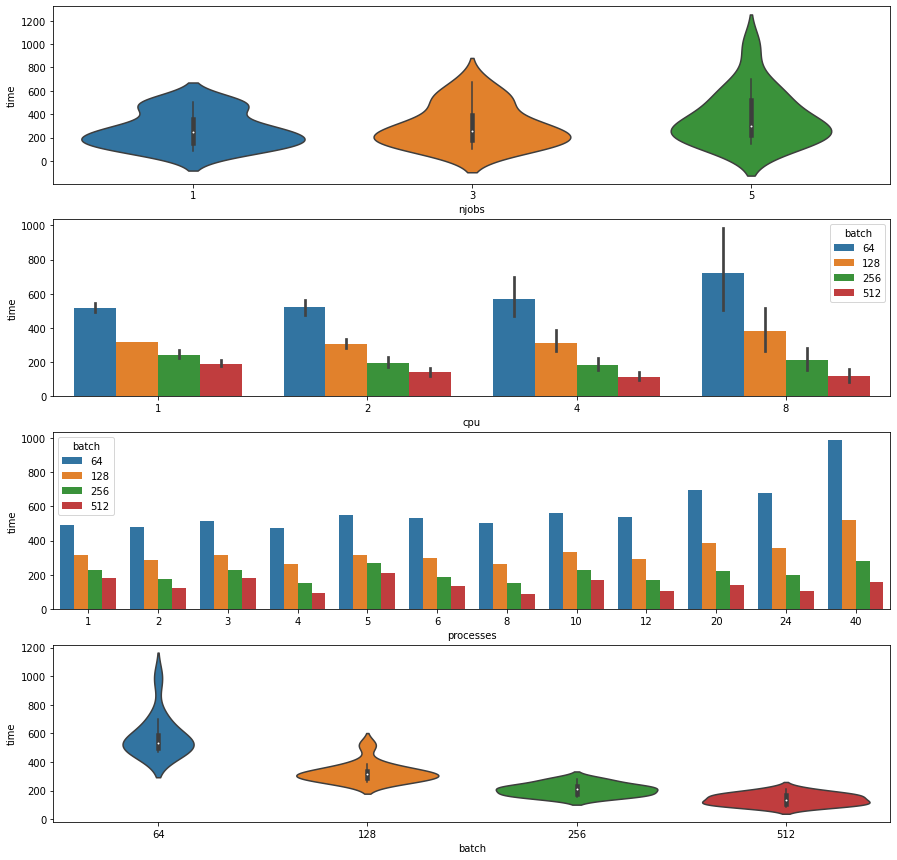

In [78]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='time', data=results_df, ax=ax1)
sns.barplot(x='cpu', y='time', hue='batch', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.barplot(x='processes', y='time', hue='batch',data=results_df, ax=ax3)
sns.violinplot(x='batch', y='time', data=results_df, ax=ax4);


### See the relationships with the accuracy


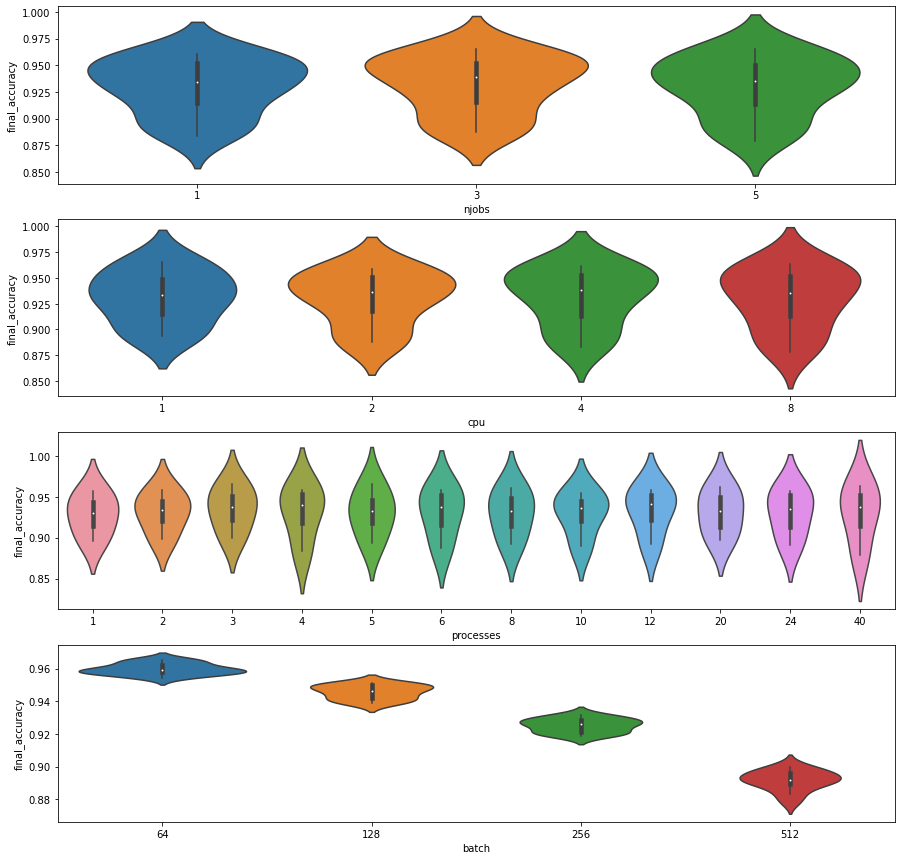

In [91]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='final_accuracy', data=results_df, ax=ax1)
sns.violinplot(x='cpu', y='final_accuracy', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.violinplot(x='processes', y='final_accuracy', data=results_df, ax=ax3)
sns.violinplot(x='batch', y='final_accuracy', data=results_df, ax=ax4);


### See the relationship with the cpu load and iowait

,cpu,njobs,time,final_accuracy,cpu_mean,iowait_mean,processes
batch,,,,,,,
64,3.75,3.0,583.650255,0.959942,11.749000,0.856546,11.25
128,3.75,3.0,328.925168,0.945767,12.469254,0.872583,11.25
256,3.75,3.0,208.621100,0.925300,13.833962,1.043823,11.25
512,3.75,3.0,140.631623,0.891600,15.987165,1.727950,11.25


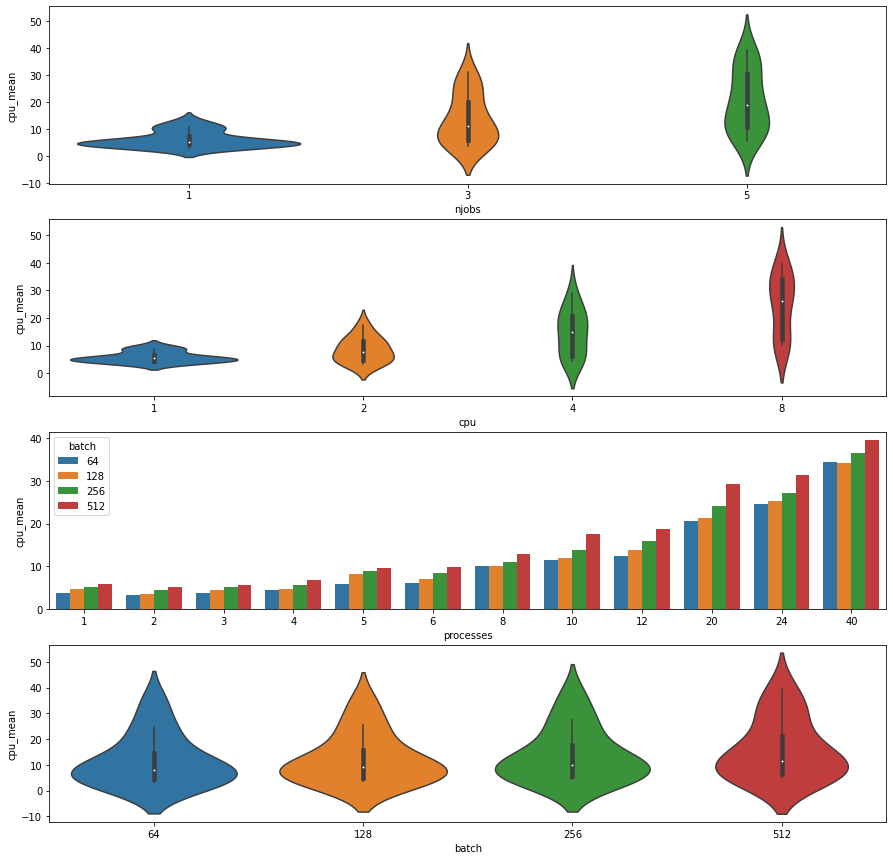

In [92]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.violinplot(x='njobs', y='cpu_mean', data=results_df, ax=ax1)
sns.violinplot(x='cpu', y='cpu_mean', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.barplot(x='processes', y='cpu_mean', hue='batch', data=results_df, ax=ax3)
sns.violinplot(x='batch', y='cpu_mean', data=results_df, ax=ax4);


# Surprisingly, the batch size doesn't influence cpu utilization??
results_df.groupby(['batch']).mean()

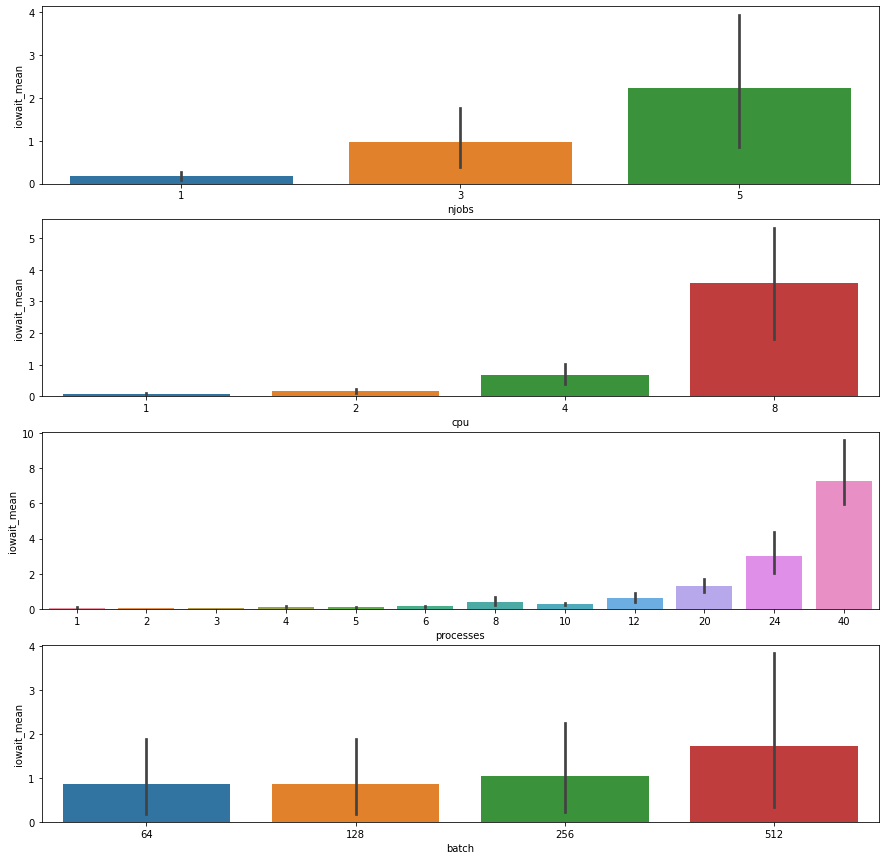

In [93]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(15,15))

sns.barplot(x='njobs', y='iowait_mean', data=results_df, ax=ax1)
sns.barplot(x='cpu', y='iowait_mean', data=results_df, ax=ax2)

results_df['processes'] = results_df['cpu'] * results_df['njobs']
sns.barplot(x='processes', y='iowait_mean', data=results_df, ax=ax3)
sns.barplot(x='batch', y='iowait_mean', data=results_df, ax=ax4);

## Run the ANOVA tests on this data 

We want to see how factors like number of CPUs, Jobs, and Batch influence all the others
- Accuracy
- E(T)
- CPU Usage
- IO Wait

In [118]:
def ANOVA(df: pd.DataFrame, y: str, use_all = False,verbose=False):
    """Run the ANOVA analysis with the cpu, batch and njobs columns for the 
    given output variable"""
    
    # If use all is true we use all the variables to check either accuracy and time
    # including also the iowait and the cpu to see what fully influences the stuff
    
    
    if not use_all:
        # Plot the summary dataframe
        if verbose:
            display(rp.summary_cont(results_df.groupby(['cpu', 'batch', 'njobs']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs', df).fit()
        
    else:
        if y not in ['final_accuracy', 'time']:
            raise ValueError('When use_all = True we predict either final_accuracy or time, not', y)
        if verbose:
            display(rp.summary_cont(results_df.groupby(['cpu', 'batch', 'njobs', 'cpu_mean', 'iowait_mean']))[y])

        model = ols(f'{y} ~ cpu*batch*njobs*cpu_mean*iowait_mean', df).fit()
        

    if verbose:
        print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}")
        display(model.summary())
    
    res = sm.stats.anova_lm(model, typ=2)
    
    return res

In [ ]:
# Simply change the output value for the y to the variable that you want to study
# - iowait_mean
# - final_accuracy
# - time
# - cpu_mean
res = ANOVA(results_df, y='time', verbose=True)
res

## Regress the datapoints we have to get an idea of the performance

In [119]:
# We want to fit the response time based on the number of processes (cpu * jobs) and the batch size

# 1) Transform the dataset
df_regr = results_df[['cpu', 'batch', 'njobs', 'time', 'final accuracy']]
df_regr['processes'] = df_regr['cpu'] * df_regr['njobs']
df_regr = df_regr[['processes', 'batch', 'time', 'final accuracy']]

X_init = df_regr[['processes', 'batch']].reset_index(drop=True)
# X = df_regr[['cpu','njobs', 'batch']].reset_index(drop=True)
y_time = df_regr['time'].reset_index(drop=True)
y_acc = df_regr['final accuracy'].reset_index(drop=True)

scaler = StandardScaler()
X = scaler.fit_transform(X_init)


c:\users\diego\cs\qpe\venv\lib\site-packages\scipy\stats\_distn_infrastructure.py:2016: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


N      Mean  SD  SE  95% Conf.  Interval
cpu batch njobs                                          
1   64    1      1  493.5107 NaN NaN        NaN       NaN
          3      1  512.4431 NaN NaN        NaN       NaN
          5      1  547.8436 NaN NaN        NaN       NaN
    128   1      1  316.2658 NaN NaN        NaN       NaN
          3      1  316.0966 NaN NaN        NaN       NaN
          5      1  315.5120 NaN NaN        NaN       NaN
    256   1      1  230.3810 NaN NaN        NaN       NaN
          3      1  226.5143 NaN NaN        NaN       NaN
          5      1  270.8785 NaN NaN        NaN       NaN
    512   1      1  179.7307 NaN NaN        NaN       NaN
          3      1  180.6815 NaN NaN        NaN       NaN
          5      1  212.3467 NaN NaN        NaN       NaN
2   64    1      1  477.4229 NaN NaN        NaN       NaN
          3      1  531.7005 NaN NaN        NaN       NaN
          5      1  563.3317 NaN NaN        NaN       NaN
    128   1      1  284.8274 NaN NaN        NaN       NaN
          3      1  298.2330 NaN NaN        NaN       NaN
          5      1  332.7909 NaN NaN        NaN       NaN
    256   1      1  173.8906 NaN NaN        NaN       NaN
          3      1  187.4503 NaN NaN        NaN       NaN
          5      1  228.5348 NaN NaN        NaN       NaN
    512   1      1  121.8168 NaN NaN        NaN       NaN
          3      1  133.4219 NaN NaN        NaN       NaN
          5      1  167.7724 NaN NaN        NaN       NaN
4   64    1      1  471.4012 NaN NaN        NaN       NaN
          3      1  538.8362 NaN NaN        NaN       NaN
          5      1  697.7254 NaN NaN        NaN       NaN
    128   1      1  264.5948 NaN NaN        NaN       NaN
          3      1  292.3667 NaN NaN        NaN       NaN
          5      1  387.3068 NaN NaN        NaN       NaN
    256   1      1  153.5192 NaN NaN        NaN       NaN
          3      1  172.5014 NaN NaN        NaN       NaN
          5      1  222.3314 NaN NaN        NaN       NaN
    512   1      1   93.3707 NaN NaN        NaN       NaN
          3      1  105.8141 NaN NaN        NaN       NaN
          5      1  141.2408 NaN NaN        NaN       NaN
8   64    1      1  502.9506 NaN NaN        NaN       NaN
          3      1  679.3357 NaN NaN        NaN       NaN
          5      1  987.3016 NaN NaN        NaN       NaN
    128   1      1  263.4090 NaN NaN        NaN       NaN
          3      1  357.5271 NaN NaN        NaN       NaN
          5      1  518.1719 NaN NaN        NaN       NaN
    256   1      1  153.9060 NaN NaN        NaN       NaN
          3      1  200.9890 NaN NaN        NaN       NaN
          5      1  282.5566 NaN NaN        NaN       NaN
    512   1      1   86.6591 NaN NaN        NaN       NaN
          3      1  105.8141 NaN NaN        NaN       NaN
          5      1  158.9105 NaN NaN        NaN       NaN

Overall model F( 7, 40) =  15.761, p =  0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     15.76
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           1.01e-09
Time:                        20:53:35   Log-Likelihood:                -287.65
No. Observations:                  48   AIC:                             591.3
Df Residuals:                      40   BIC:                             606.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         443.4141     94.765      4.679      0.000     251.887     634.941
cpu               -17.0859     20.557     -0.831      0.411     -58.634      24.462
batch              -0.6528      0.321     -2.032      0.049      -1.302      -0.004
cpu:batch           0.0111      0.070      0.159      0.874      -0.130       0.152
njobs              -7.9097     27.744     -0.285      0.777     -63.983      48.164
cpu:njobs          14.1792      6.019      2.356      0.023       2.015      26.343
batch:njobs         0.0341      0.094      0.363      0.719      -0.156       0.224
cpu:batch:njobs    -0.0287      0.020     -1.407      0.167      -0.070       0.013
==============================================================================
Omnibus:                        3.575   Durbin-Watson:                   0.849
Prob(Omnibus):                  0.167   Jarque-Bera (JB):                2.124
Skew:                           0.280   Prob(JB):                        0.346
Kurtosis:                       2.135   Cond. No.                     3.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,sum_sq,df,F,PR(>F)
cpu,19094.159772,1.0,1.693967,2.005254e-01
batch,978115.802048,1.0,86.774996,1.433490e-11
cpu:batch,57209.677792,1.0,5.075442,2.982124e-02
njobs,97560.388448,1.0,8.655215,5.402699e-03
cpu:njobs,48874.103254,1.0,4.335939,4.375595e-02
batch:njobs,20390.966302,1.0,1.809015,1.862031e-01
cpu:batch:njobs,22326.204801,1.0,1.980702,1.670401e-01
Residual,450874.489201,40.0,NaN,NaN


## Regress the datapoints we have to get an idea of the performance

In [127]:
# We want to fit the response time based on the number of processes (cpu * jobs) and the batch size

# 1) Transform the dataset
df_regr = results_df[['cpu', 'batch', 'njobs', 'time', 'final accuracy']]
df_regr['processes'] = df_regr['cpu'] * df_regr['njobs']
df_regr = df_regr[['processes', 'batch', 'time', 'final accuracy']]

X_init = df_regr[['processes', 'batch']].reset_index(drop=True)
# X = df_regr[['cpu','njobs', 'batch']].reset_index(drop=True)
y_time = df_regr['time'].reset_index(drop=True)
y_acc = df_regr['final accuracy'].reset_index(drop=True)

scaler = StandardScaler()
X = scaler.fit_transform(X_init)


c:\users\diego\cs\qpe\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# Scale the data

%matplotlib inline

scaler = StandardScaler()
xtrain = scaler.fit_transform(X)
# print(xtrain)

# PLot the datapoints
from mpl_toolkits.mplot3d import Axes3D

# plot the train examples
f = plt.figure()
ax = Axes3D(f)
print(xtrain.shape, y.ravel().shape)
ax.scatter(xtrain[:,0], xtrain[:,1], y, c='r')

# Fit a simple linear regression
regressors = [LinearRegression(), Lasso(alpha=1), Ridge(), DecisionTreeRegressor(), RandomForestRegressor()]

# Try with second order stats
x_2 = xtrain**2
xtrain_2 = np.concatenate((xtrain, xtrain**2, xtrain**3), axis =1)
# print(xtrain_2)

for r in regressors:
    loo = LeaveOneOut()

    scores = cross_validate(r, xtrain, y, cv=loo, scoring='neg_mean_squared_error')

    print(r,scores)


x1,x2 = np.meshgrid(np.linspace(-2,2), np.linspace(-2,2))

lr = regressors[0].fit(xtrain, y)
inter = lr.intercept_
coefs = lr.coef_

y_out = coefs[0]*x1+coefs[1]*x2 + inter
print(inter, coefs)
ax.plot_wireframe(x1,x2,y_out);

In [45]:
# Fit just the Random Forest regressor with a GridSearch crossval to find the best hyperparams

from sklearn.model_selection import GridSearchCV, train_test_split

x_train, x_test, y_train_acc, y_test_acc = train_test_split(X, y_acc, test_size=0.2, random_state = 42)
x_train, x_test, y_train_time, y_test_time = train_test_split(X, y_time, test_size=0.2, random_state = 42)

reg_acc = RandomForestRegressor(random_state=42)
reg_time = RandomForestRegressor(random_state=42)

params_rf = {
    'n_estimators': [50, 100, 150, 200, 500,100],
    'max_features': ['auto', 'log2', 'sqrt'],
    'max_depth': range(4,10),
    'criterion': ['mse', 'mae']
    
}

# First cross validation
print('Fitting the time...')
cv_time = GridSearchCV(estimator=reg_time, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_time.fit(x_train, y_train_time)


# Second cross val
print('Fitting the accuracy')
cv_acc = GridSearchCV(estimator=reg_acc, param_grid=params_rf, n_jobs=8, cv=5, verbose=3)
cv_acc.fit(x_train, y_train_acc)

Fitting the time...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 208 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 528 tasks      | elapsed:   18.4s
[Parallel(n_jobs=8)]: Done 976 tasks      | elapsed:   36.3s
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed:   40.4s finished


Fitting the accuracy
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 208 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 528 tasks      | elapsed:   19.1s
[Parallel(n_jobs=8)]: Done 976 tasks      | elapsed:   36.4s
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed:   41.0s finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=8,
             param_grid={'criterion': ['mse', 'mae'], 'max_depth': range(4, 10),
                         'max_features': ['auto', 'log2', 'sqrt'],
                         'n_estimators': [50, 100, 150, 200, 500, 100]},
             verbose=3)

In [46]:
cv_time.best_params_

{'criterion': 'mae',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 500}

In [47]:
cv_acc.best_params_

{'criterion': 'mae',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 500}

### Fit the regressors on the accuracy and time

In [48]:
from sklearn.metrics import mean_squared_error

# 1) Fit on the time
r_t = cv_time.best_estimator_.fit(x_train, y_train_time)

# test the performance on the train and the test set
y_pred = r_t.predict(x_test)

err = mean_squared_error(y_pred, y_test_time)

print('Mean Squared Error with the test set is for TIME', err)


# 2) Fit on the acc
r_acc = cv_acc.best_estimator_.fit(x_train, y_train_acc)

# test the performance on the train and the test set
y_pred = r_acc.predict(x_test)
err = mean_squared_error(y_pred, y_test_acc)

print('Mean Squared Error with the test set is for ACCURACY', err)

Mean Squared Error with the test set is for TIME 1024.8644910549706
Mean Squared Error with the test set is for ACCURACY 1.4282332284000623e-05


In [ ]:
# Run some examples with it

## Create the Final Optimizer that will multiplex the regressors seen above

In [188]:
# Import the 3 regressors
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut, cross_validate


from typing import Tuple, Optional
# Declare the class for the ML model

from dataclasses import dataclass

@dataclass
class Job:
    cpu:int
    njobs: int


class Courier:
    """ Courier has 3 parameters to account for utilization, accuracy and response time,
    based on which, and their weights, it chooses the optimal batch size for the task

    labels are in format dict
    accuracy -> labels
    time -> labels
    utilization -> labels
    """

    def __init__(self, alpha: float, beta: float,
                models: dict, scaler, batches=[64,128,256,512]):


        self.batches = np.array(batches).reshape(len(batches), 1)
        

        if alpha + beta !=1:
            raise ValueError('The hyperparameters need to add up to 1')

        # Configure the hyperparams and the training data
        self.alpha = alpha
        self.beta = beta
        
        
        self.scaler = scaler

        # Compute the predictors
        self.acc_model = models['accuracy']
        self.time_model = models['time']

    def optimize(self, job: Job, latency = None):
        acc, t = self._predict(job)
        
        b = self.batches


        if latency:
            # Just take the options that satisfy the requirements
            fit = t[t<latency]
            if len(fit) == 0:
                print('Not a single value fulfills the '
                      'time requirements, selecting minimum time')
                # Return the minimum time
                min_t_idx = np.where(t == t.min())[0][0]
                return self.batches[min_t_idx], (acc[min_t_idx],
                                                 t[min_t_idx])

            else:
                acc = acc[t<latency]
                b = self.batches[t<latency]
                t = t[t<latency]


        # Return the batch that better fulfills the requirements and
        # also return a tuple with the predictions
        sc_a = acc/np.max(acc)
        sc_t = 1-( t/np.max(t))

        sc = self.alpha * sc_a + self.beta * sc_t

        # Get the index of the max score
        max_sc_idx = np.where(sc == sc.max())[0][0]
        return  b[max_sc_idx], (acc[max_sc_idx],
                                           t[max_sc_idx])



    def _fit_model(self, labels):
        """Fit the model to particular labels"""
        reg = self.model
        reg.fit(self.X, labels)
        return reg


    def _preprocess_data(self, X):
        """Standardizes the data"""
        scaler = StandardScaler()
        return scaler.fit_transform(X)

    def _predict(self, job: Job):
        """Predicts the time, accuracy and util with different batches
        and returns the best one given the optims"""

        acc = []
        t = []
        
        # predict the performance of the job with different batches
        for b in self.batches:
            data_point = self.scaler.transform([[job.cpu * job.njobs, b]])
            _acc = self.acc_model.predict(data_point)
            _t = self.time_model.predict(data_point)
            print(f'Batch {b}, acc = {_acc} and t = {_t}')

            acc.append(_acc)
            t.append(_t)


        return np.array(acc), np.array(t)




In [189]:
# Create the Courier

c = Courier(alpha = 0.95, beta=0.05, 
            models= {
                'accuracy': r_acc,
                'time': r_t
},
           scaler=scaler)

In [194]:
# Get some predidctions from the Courier

j = Job(cpu = 10, njobs=8)
batch, prediction = c.optimize(j, latency=400)

print(f'Recommended batch {batch}, predictions {prediction}')

Batch [64], acc = [0.961207] and t = [861.33313804]
Batch [128], acc = [0.9483] and t = [453.20116822]
Batch [256], acc = [0.9246403] and t = [244.08488156]
Batch [512], acc = [0.8841731] and t = [160.87720236]
Recommended batch 256, predictions (0.9246403000000044, 244.08488156318916)


## Run the ANOVA test with all of the results


In [ ]:



# Get the last accuracy instead of the list for the accuracy of each of the experiments

df = pd.DataFrame(res_final)

df